# Classification and Regression Trees

**Classification and Regression Trees**: CART (Classification and Regression Trees) is a decision tree-based algorithm and is used to solve both classification and regression problems. The CART algorithm creates a decision tree using the dataset and classifies data points or makes regression predictions using this tree structure.

The CART algorithm tries to choose the best splitting point using a certain measure (criterion) at each splitting step. One of the commonly used criteria for classification is **Gini impurity** or **Entropy**. For regression, MSE (Mean Squared Error) is generally used.

# Import Necessary Libraries

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text

!pip install pydotplus
!pip install astor
!pip install skompiler
!pip install joblib
from skompiler import skompile
import pydotplus
import graphviz
import joblib

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# General Information About to the Dataset

In [4]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

######################### Head #########################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.6000                    0.6270   50        1
1            1       85             66             29        0 26.6000                    0.3510   31        0
2            8      183             64              0        0 23.3000                    0.6720   32        1
3            1       89             66             23       94 28.1000                    0.1670   21        0
4            0      137             40             35      168 43.1000                    2.2880   33        1
######################### Tail #########################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.9000                    0.1710   63    

# Analysis of Categorical and Numerical Variables

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [7]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"Num_But_Cat: {len(num_but_cat)}")

Observations: 768
Variables: 9
Cat_cols: 1
Num_cols: 8
Cat_but_car: 0
Num_But_Cat: 1


In [8]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [9]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

         Outcome  Ration
Outcome                 
0            500 65.1042
1            268 34.8958
##########################################


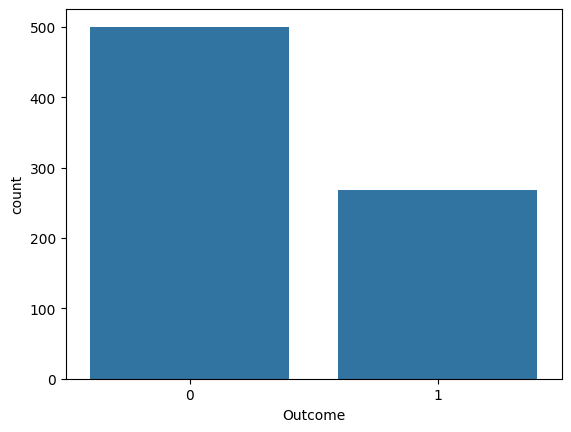

In [10]:
cat_summary_df(df)

In [11]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [12]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   768.0000
mean      3.8451
std       3.3696
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       1.0000
30%       1.0000
40%       2.0000
50%       3.0000
60%       4.0000
70%       5.0000
80%       7.0000
90%       9.0000
95%      10.0000
99%      13.0000
max      17.0000
Name: Pregnancies, dtype: float64


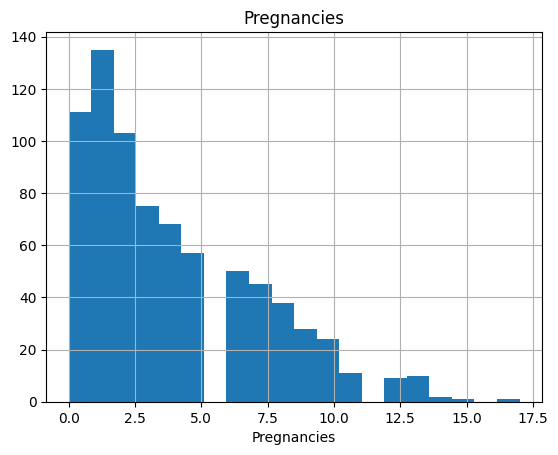

count   768.0000
mean    120.8945
std      31.9726
min       0.0000
1%       57.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
max     199.0000
Name: Glucose, dtype: float64


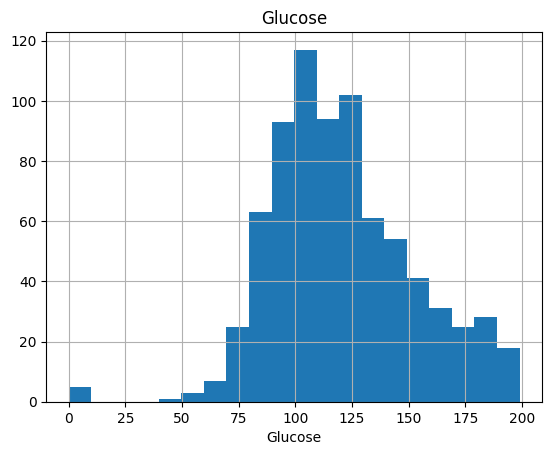

count   768.0000
mean     69.1055
std      19.3558
min       0.0000
1%        0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
max     122.0000
Name: BloodPressure, dtype: float64


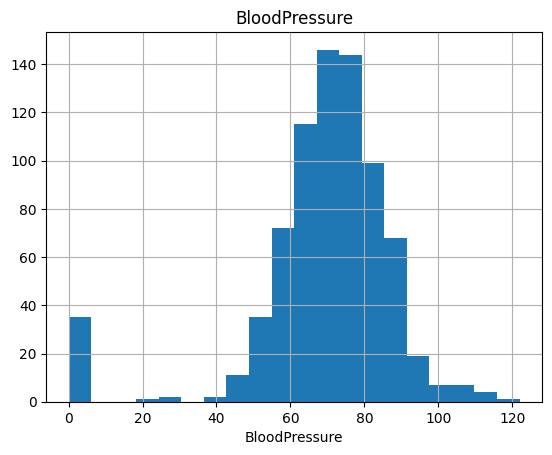

count   768.0000
mean     20.5365
std      15.9522
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
max      99.0000
Name: SkinThickness, dtype: float64


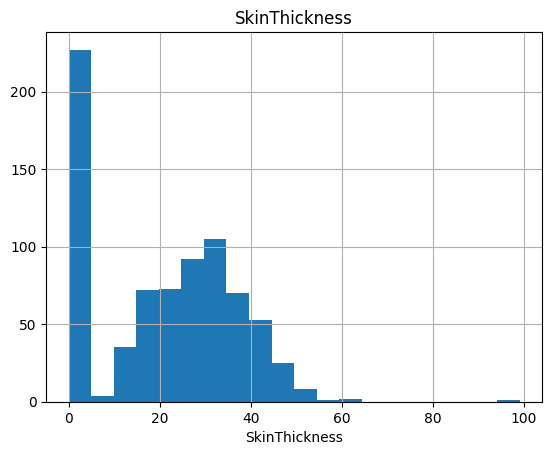

count   768.0000
mean     79.7995
std     115.2440
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
max     846.0000
Name: Insulin, dtype: float64


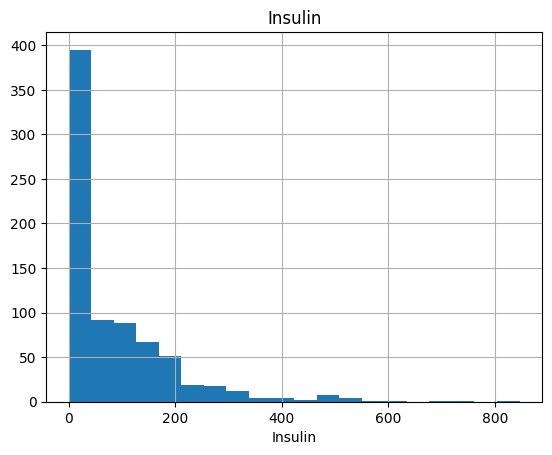

count   768.0000
mean     31.9926
std       7.8842
min       0.0000
1%        0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
max      67.1000
Name: BMI, dtype: float64


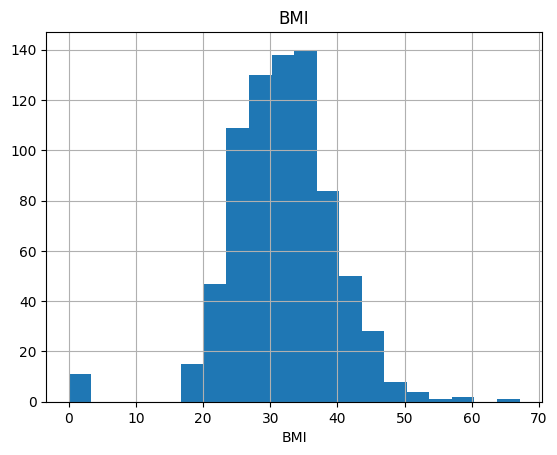

count   768.0000
mean      0.4719
std       0.3313
min       0.0780
1%        0.0947
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


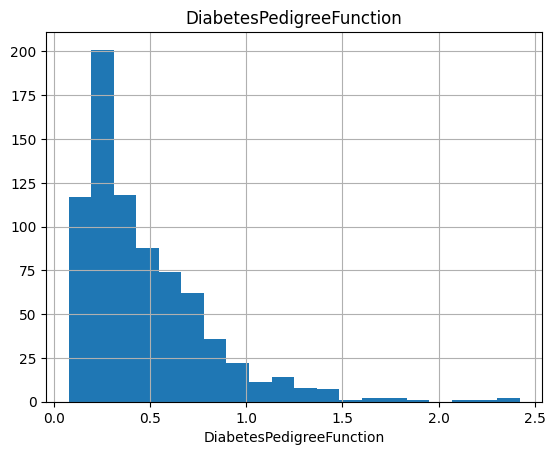

count   768.0000
mean     33.2409
std      11.7602
min      21.0000
1%       21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
max      81.0000
Name: Age, dtype: float64


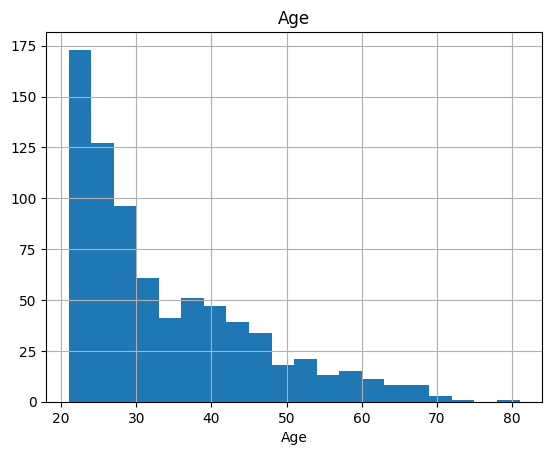

In [13]:
num_summary_df(df)

In [14]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(12,8))
  for index, col in enumerate(num_cols):
    plt.subplot(3,3, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

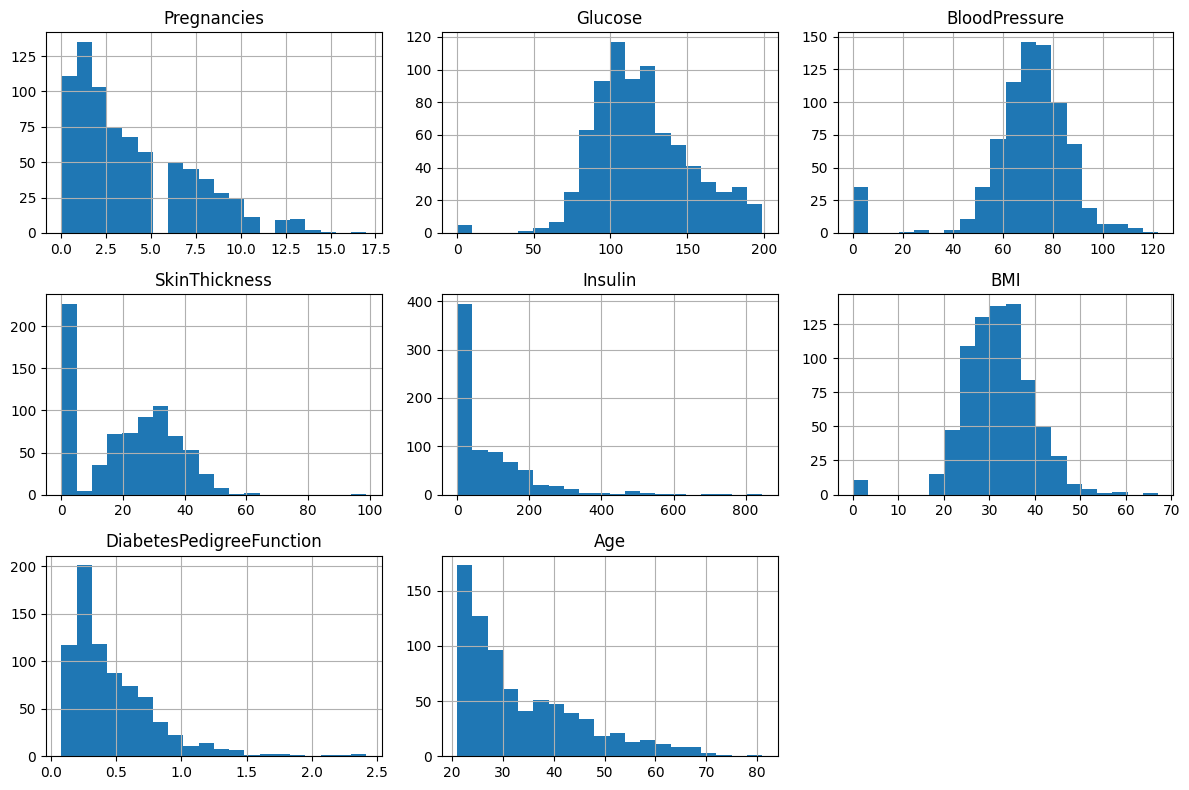

In [15]:
plot_num_summary(df)

# Target Analysis

In [16]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(dataframe.groupby(target).agg({numerical_col: "mean"}))
  print("#############################################")

In [17]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [18]:
target_summary_with_num_df(df, "Outcome")

         Pregnancies
Outcome             
0             3.2980
1             4.8657
#############################################
         Glucose
Outcome         
0       109.9800
1       141.2575
#############################################
         BloodPressure
Outcome               
0              68.1840
1              70.8246
#############################################
         SkinThickness
Outcome               
0              19.6640
1              22.1642
#############################################
         Insulin
Outcome         
0        68.7920
1       100.3358
#############################################
            BMI
Outcome        
0       30.3042
1       35.1425
#############################################
         DiabetesPedigreeFunction
Outcome                          
0                          0.4297
1                          0.5505
#############################################
            Age
Outcome        
0       31.1900
1       37.0672
##########

# Correlation Analysis

In [19]:
def correlated_cols(dataframe, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  print(corr)

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
    plt.show()

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction     Age  Outcome
Pregnancies                    1.0000   0.1295         0.1413        -0.0817  -0.0735 0.0177                   -0.0335  0.5443   0.2219
Glucose                        0.1295   1.0000         0.1526         0.0573   0.3314 0.2211                    0.1373  0.2635   0.4666
BloodPressure                  0.1413   0.1526         1.0000         0.2074   0.0889 0.2818                    0.0413  0.2395   0.0651
SkinThickness                 -0.0817   0.0573         0.2074         1.0000   0.4368 0.3926                    0.1839 -0.1140   0.0748
Insulin                       -0.0735   0.3314         0.0889         0.4368   1.0000 0.1979                    0.1851 -0.0422   0.1305
BMI                            0.0177   0.2211         0.2818         0.3926   0.1979 1.0000                    0.1406  0.0362   0.2927
DiabetesPedigreeFunction      -0.0335   0.1373  

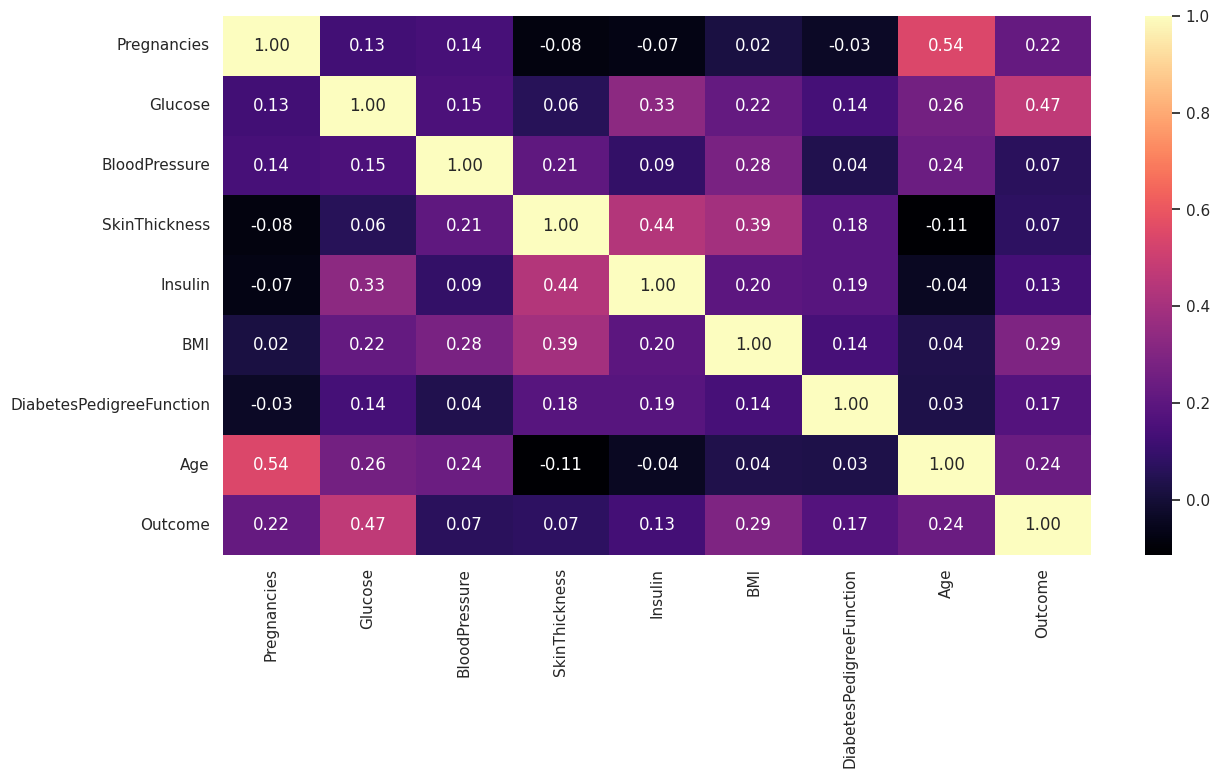

In [20]:
correlated_cols(df, plot=True)

In [21]:
def high_correlated_cols(dataframe, corr_th = 0.90, plot=False):
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr = dataframe[num_cols].corr()
  corr_matrix = corr.abs()
  upper_triangular_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangular_matrix.columns if any(upper_triangular_matrix[col] > corr_th)]
  if drop_list == []:
    print("Aftre corelation analysis, we dont need to remove variables")

  if plot:
    sns.set(rc={'figure.figsize': (14,7)})
    sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
    plt.show()

  return drop_list

Aftre corelation analysis, we dont need to remove variables


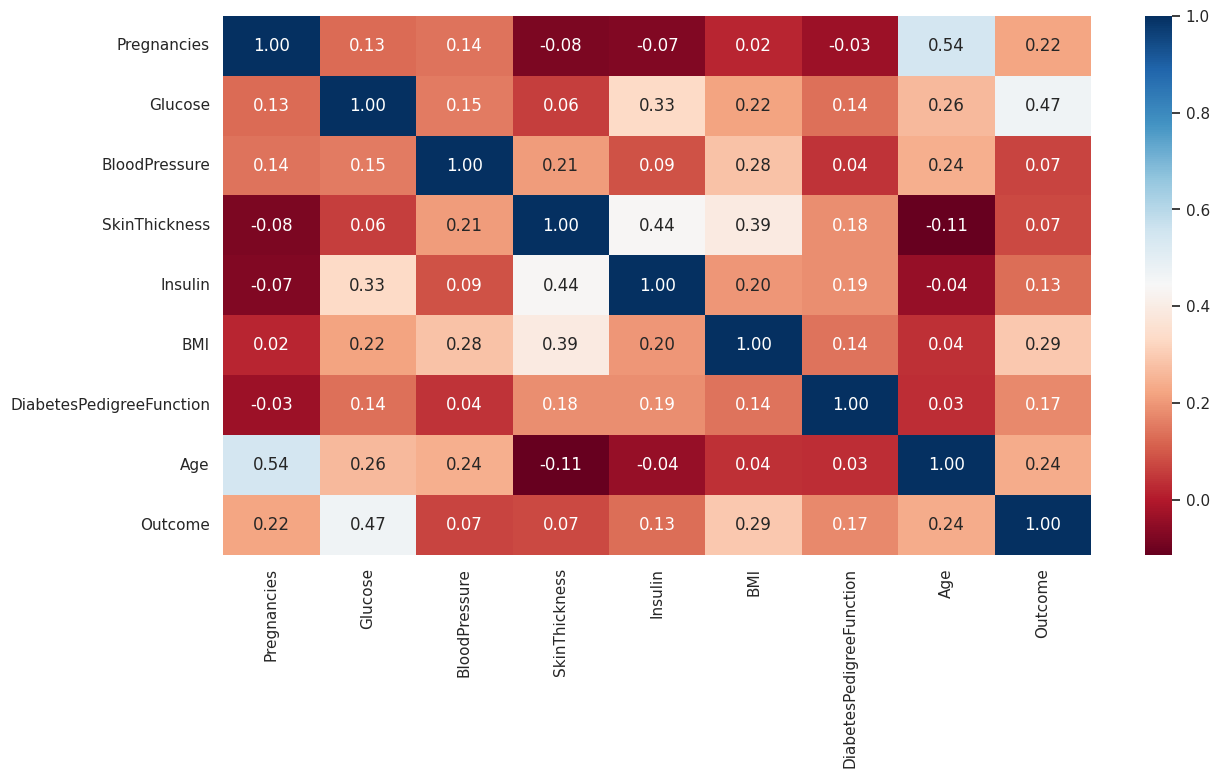

In [22]:
drop_list = high_correlated_cols(df, plot=True)

## Missing Value Analysis

**Not:** It is known that a human cannot have variable values 0 other than Pregnancies and Outcome. Therefore, an action decision should be taken regarding these values. Values that are 0 can be assigned NaN.


In [23]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [24]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_columns:
  df[col] = np.where(df[col]==0, np.nan, df[col])

In [25]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [26]:
def missing_value_table(dataframe, na_names=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

  if na_names:
    print(25*"#", "NA Columns", 25*"#")
    return na_columns

In [27]:
na_columns = missing_value_table(df, na_names=True)

               n_miss   ratio
Insulin           374 48.7000
SkinThickness     227 29.5600
BloodPressure      35  4.5600
BMI                11  1.4300
Glucose             5  0.6500
######################### NA Columns #########################


In [28]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [29]:
df = fill_na_with_median(df)

In [30]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Outlier Analysis

In [31]:
def outlier_thresholds(dataframe,col_name,q1=0.05,q3=0.95):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [32]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [33]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [34]:
for col in df.columns:
  print(col, check_outlier(df, col))
  if check_outlier(df, col):
    replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [35]:
for col in df.columns:
  print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


# Encoding & Scaling

In [36]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

In [37]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [38]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

In [39]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
def one_hot_encoding(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

In [40]:
df = one_hot_encoding(df, cat_cols, drop_first=True)

In [41]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0000,72.0000,35.0000,125.0000,33.6000,0.6270,50,1
1,1,85.0000,66.0000,29.0000,125.0000,26.6000,0.3510,31,0
2,8,183.0000,64.0000,29.0000,125.0000,23.3000,0.6720,32,1
3,1,89.0000,66.0000,23.0000,94.0000,28.1000,0.1670,21,0
4,0,137.0000,40.0000,35.0000,168.0000,43.1000,2.2880,33,1


# Create a Base Classifier Model: Classification and Regression Trees

**Classification and Regression Trees**: CART (Classification and Regression Trees) is a decision tree-based algorithm and is used to solve both classification and regression problems. The CART algorithm creates a decision tree using the dataset and classifies data points or makes regression predictions using this tree structure.

The CART algorithm tries to choose the best splitting point using a certain measure (criterion) at each splitting step. One of the commonly used criteria for classification is **Gini impurity** or **Entropy**. For regression, MSE (Mean Squared Error) is generally used.

In [57]:
def CART_Model(dataframe, target, test_size=0.30, cv=10, results=False, plot_importance=False, tree_graph=False, tree_rules=False, export_rules="python", save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

  cart_model = DecisionTreeClassifier().fit(X_train, y_train)

  if results:
    acc_train = accuracy_score(y_train, cart_model.predict(X_train))
    acc_test = accuracy_score(y_test, cart_model.predict(X_test))
    r2 = cart_model.score(X, y)
    r2_train = cart_model.score(X_train, y_train)
    r2_test = cart_model.score(X_test, y_test)
    cv_train = cross_val_score(cart_model, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(cart_model, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(cart_model, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': cart_model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

  if tree_graph:
    tree_str = export_graphviz(cart_model, feature_names=X.columns, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png("cart_tree_graph.png")

  if tree_rules:
    tree_rules = export_text(cart_model, feature_names=list(X.columns))
    print(tree_rules)

  if export_rules:
    if export_rules == "python":
      rules = skompile(cart_model.predict).to('python/code')
    elif export_rules == "excel":
      rules = skompile(cart_model.predict).to('excel')
    #elif export_rules == "sql":
    #  rules = skompile(cart_model.predict).to('sqlalchemy/sqlite')
    else:
      print("Error in export rules")

  if save_model:
    joblib.dump(cart_model, "cart_model.pkl")

  return cart_model, rules

##################### Accuracy & R2 Metrics ######################
Accuracy_train:  1.000
Accuracy_test:  0.701
R2:  0.940
R2_train:  1.000
R2_test:  0.701
Cross Validation Score(Train):  0.690
Cross Validation Score(Test):  0.682
Cross Validate (Accuracy):  0.697
Cross Validate (Precision):  0.567
Cross Validate (Recall):  0.563
Cross Validate (F1):  0.562
Cross Validate (ROC AUC Score):  0.666


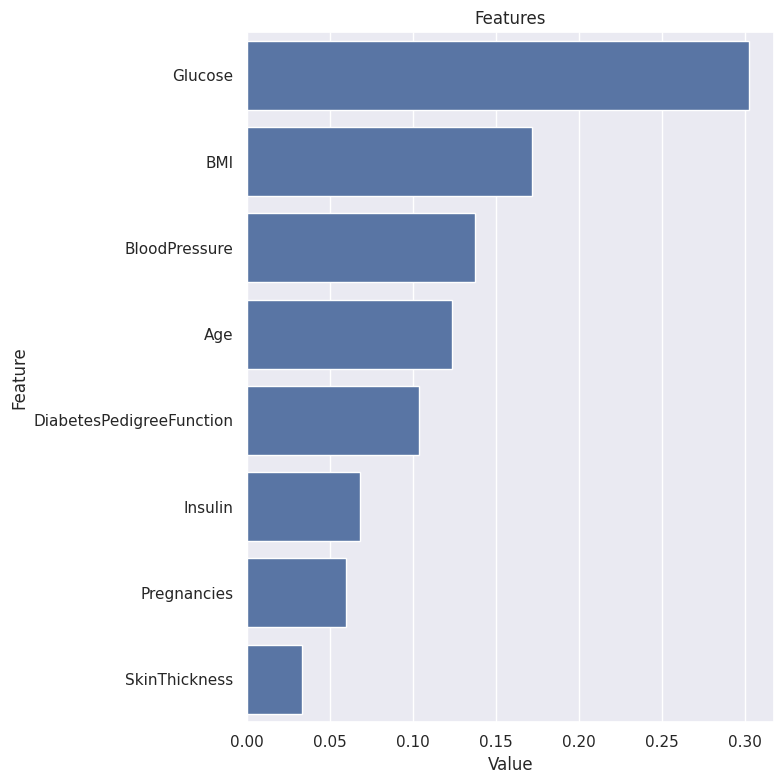

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.00
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.67
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiabetesPedigreeFunction >  0.67
|   |   |   |   |   |   |--- Insulin <= 53.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Insulin >  53.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.90
|   |   |   |   |   |--- Age <= 22.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Age >  22.50
|   |   |   |   |   |   |--- BMI <= 31.10
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- BMI >  31.10
|   |   |   |   |   |   |   |--- Insulin <= 36.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- 

In [58]:
cart_model, rules = CART_Model(df, "Outcome", results=True, plot_importance=True, tree_graph=True, tree_rules=True, save_model=True)

In [59]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

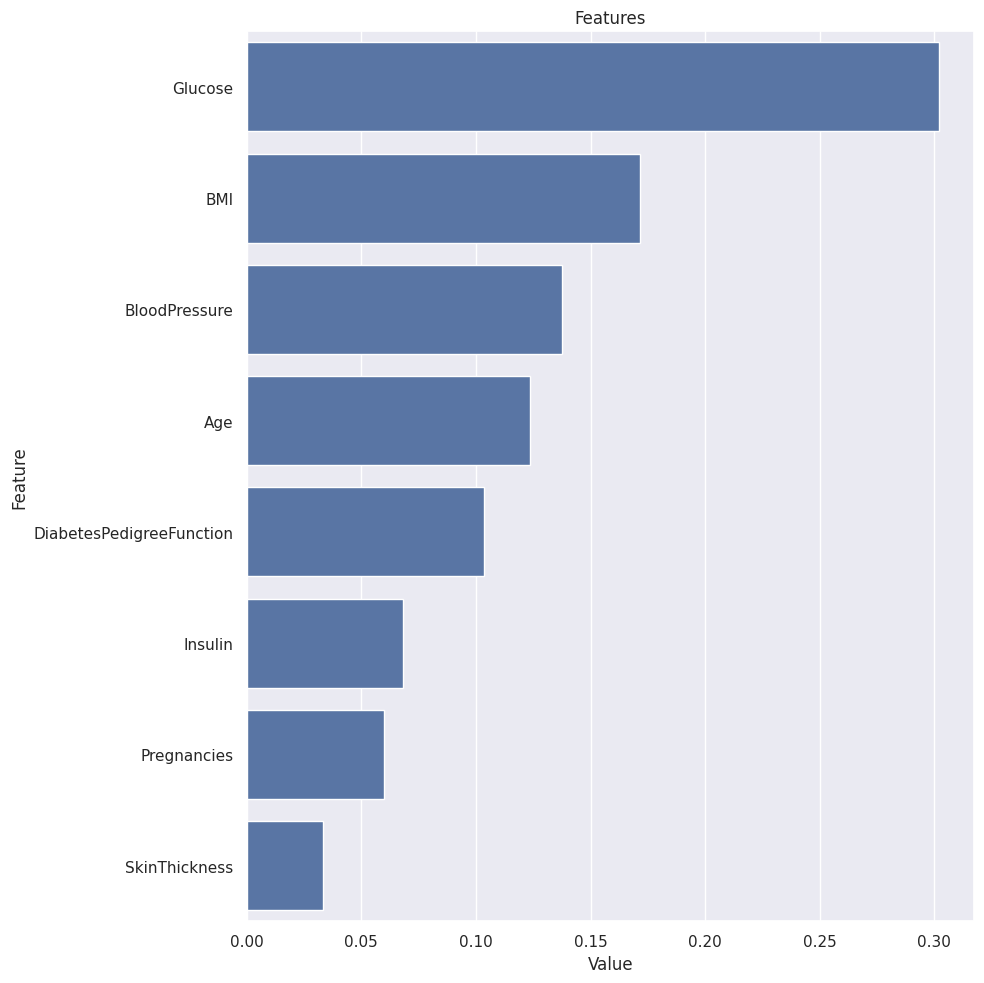

In [60]:
plot_importance(cart_model, X)

In [61]:
def val_curve_params(model, X, y, param_name, param_range, scoring="neg_mean_squared_error", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

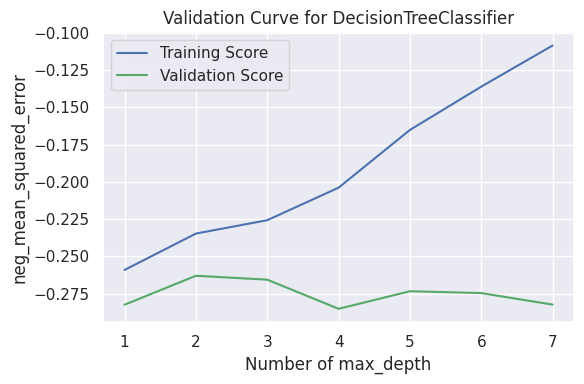

In [64]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
cart_model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
val_curve_params(cart_model, X, y, "max_depth", range(1, X.shape[1]))

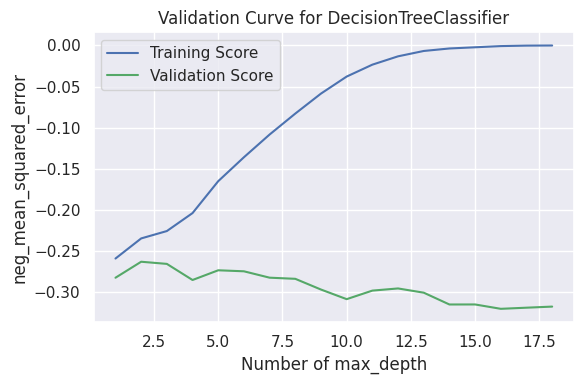

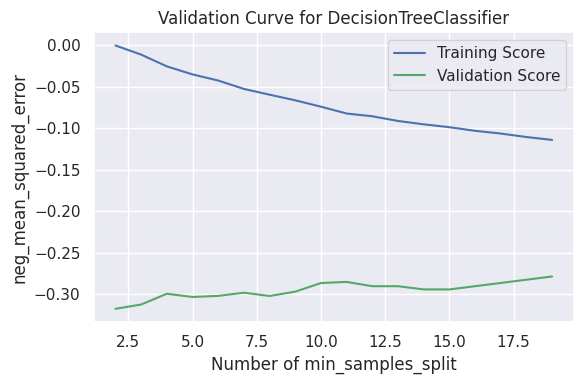

In [65]:
cart_val_params = [["max_depth", range(1, 19)], ["min_samples_split", range(2, 20)]]

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [66]:
def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)

In [67]:
tree_graph(model=cart_model, col_names=X.columns, file_name="cart_final.png")

# Loading a CART Classifier Model and Then Prediction

In [68]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [69]:
model_disc = load_model("cart_model.pkl")

In [70]:
patient = [5, 140, 90, 25, 150, 39, 0.55, 65]

In [71]:
model_disc.predict(pd.DataFrame(patient).T)[0]

1

In [72]:
X = df.drop("Outcome", axis=1)
random_patient = X.sample(1)

In [73]:
random_patient

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
59,0,105.0000,64.0000,41.0000,142.0000,41.5000,0.1730,22


In [74]:
model_disc.predict(random_patient)[0]

0

# Create a Classifier Model Tuning: Classification and Regression Trees


In [96]:
def CART_Model_Tuned(dataframe, target, test_size=0.30, cv=10, results=False, plot_importance=False, tree_graph=False, tree_rules=False, export_rules="python", save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

  cart_model = DecisionTreeClassifier()
  cart_params = {
    "max_depth": list(range(1,10)),
    "min_samples_split": list(range(2,50))
  }
  cart_cv_model = GridSearchCV(cart_model, cart_params, cv=cv, verbose=True, n_jobs=-1).fit(X_train, y_train)
  cart_model_tuned = cart_model.set_params(**cart_cv_model.best_params_).fit(X, y)

  if results:
    acc_train = accuracy_score(y_train, cart_model_tuned.predict(X_train))
    acc_test = accuracy_score(y_test, cart_model_tuned.predict(X_test))
    r2 = cart_model_tuned.score(X, y)
    r2_train = cart_model_tuned.score(X_train, y_train)
    r2_test = cart_model_tuned.score(X_test, y_test)
    cv_train = cross_val_score(cart_model_tuned, X_train, y_train, cv=cv).mean()
    cv_test = cross_val_score(cart_model_tuned, X_test, y_test, cv=cv).mean()
    cv_results = cross_validate(cart_model_tuned, X, y, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    print("##################### Accuracy & R2 Metrics ######################")
    print("CART Calssifier Best Params: ", cart_cv_model.best_params_)
    print("Accuracy_train: ", "%.3f" % acc_train)
    print("Accuracy_test: ", "%.3f" % acc_test)
    print("R2: ", "%.3f" % r2)
    print("R2_train: ", "%.3f" % r2_train)
    print("R2_test: ", "%.3f" % r2_test)
    print("Cross Validation Score(Train): ", "%.3f" % cv_train)
    print("Cross Validation Score(Test): ", "%.3f" % cv_test)
    print("Cross Validate (Accuracy): ", "%.3f" % cv_results['test_accuracy'].mean())
    print("Cross Validate (Precision): ", "%.3f" % cv_results['test_precision'].mean())
    print("Cross Validate (Recall): ", "%.3f" % cv_results['test_recall'].mean())
    print("Cross Validate (F1): ", "%.3f" % cv_results['test_f1'].mean())
    print("Cross Validate (ROC AUC Score): ", "%.3f" % cv_results['test_roc_auc'].mean())

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': cart_model_tuned.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

  if tree_graph:
    tree_str = export_graphviz(cart_model_tuned, feature_names=X.columns, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png("cart_tree_graph.png")

  if tree_rules:
    tree_rules = export_text(cart_model_tuned, feature_names=list(X.columns))
    print(tree_rules)

  if export_rules:
    if export_rules == "python":
      rules = skompile(cart_model_tuned.predict).to('python/code')
    elif export_rules == "excel":
      rules = skompile(cart_model_tuned.predict).to('excel')
    #elif export_rules == "sql":
    #  rules = skompile(cart_model_tuned.predict).to('sqlalchemy/sqlite')
    else:
      print("Error in export rules")

  if save_model:
    joblib.dump(cart_model_tuned, "cart_model_tuned.pkl")

  return cart_model_tuned, rules

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
##################### Accuracy & R2 Metrics ######################
CART Calssifier Best Params:  {'max_depth': 5, 'min_samples_split': 6}
Accuracy_train:  0.818
Accuracy_test:  0.848
R2:  0.827
R2_train:  0.818
R2_test:  0.848
Cross Validation Score(Train):  0.749
Cross Validation Score(Test):  0.706
Cross Validate (Accuracy):  0.725
Cross Validate (Precision):  0.632
Cross Validate (Recall):  0.541
Cross Validate (F1):  0.569
Cross Validate (ROC AUC Score):  0.757


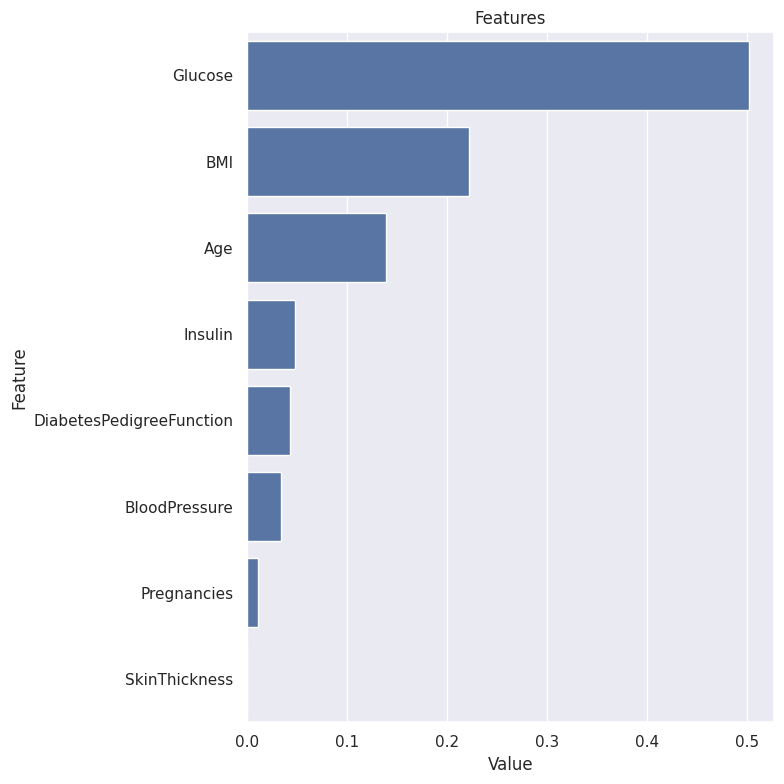

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- Pregnancies <= 7.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Pregnancies >  7.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- class: 1
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- DiabetesPedigreeFunction <= 0.80
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DiabetesPedigreeFunction >  0.80
|   |   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  99.50
|   |   |   |   |--- Insulin <= 112.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Insulin >  112.00
|   |   |   |   |   |--- class: 1
|

In [97]:
cart_model_tuned, rules = CART_Model_Tuned(df, "Outcome", results=True, plot_importance=True, tree_graph=True, tree_rules=True, export_rules="python", save_model=True)

# Loading a CART Classifier Model Tuned and Then Prediction

In [86]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [87]:
model_disc = load_model("cart_model_tuned.pkl")

In [88]:
patient = [5, 140, 90, 25, 150, 39, 0.55, 65]

In [89]:
model_disc.predict(pd.DataFrame(patient).T)[0]

1

In [90]:
X = df.drop("Outcome", axis=1)
random_patient = X.sample(1)

In [91]:
random_patient

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
150,1,136.0000,74.0000,50.0000,204.0000,37.4000,0.3990,24


In [92]:
model_disc.predict(random_patient)[0]

0

# Example of Prediction with Rules

In [99]:
rules

'(((((0 if x[0] <= 7.0 else 1) if x[5] <= 30.949999809265137 else 0 if x[6] <=\n    0.5005000084638596 else 0) if x[5] <= 45.39999961853027 else 1) if x[7] <=\n    28.5 else 0 if x[5] <= 26.350000381469727 else (0 if x[6] <= \n    0.7960000038146973 else 0) if x[1] <= 99.5 else 0 if x[4] <= 112.0 else\n    1) if x[1] <= 127.5 else (((0 if x[5] <= 28.149999618530273 else 1) if \n    x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <= 25.5 else 1 if\n    x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137 else ((1 if x[2] <= \n    73.0 else 0) if x[7] <= 30.5 else 1 if x[6] <= 0.4294999986886978 else \n    1) if x[1] <= 157.5 else 0 if x[4] <= 80.0 else 1 if x[5] <= \n    46.10000038146973 else 0)\n'

In [100]:
def predict_with_rules(x):
  return (((((0 if x[0] <= 7.0 else 1) if x[5] <= 30.949999809265137 else 0 if x[6] <=
    0.5005000084638596 else 0) if x[5] <= 45.39999961853027 else 1) if x[7] <=
    28.5 else 0 if x[5] <= 26.350000381469727 else (0 if x[6] <=
    0.7960000038146973 else 0) if x[1] <= 99.5 else 0 if x[4] <= 112.0 else
    1) if x[1] <= 127.5 else (((0 if x[5] <= 28.149999618530273 else 1) if
    x[4] <= 132.5 else 0) if x[1] <= 145.5 else 0 if x[7] <= 25.5 else 1 if
    x[7] <= 61.0 else 0) if x[5] <= 29.949999809265137 else ((1 if x[2] <=
    73.0 else 0) if x[7] <= 30.5 else 1 if x[6] <= 0.4294999986886978 else
    1) if x[1] <= 157.5 else 0 if x[4] <= 80.0 else 1 if x[5] <=
    46.10000038146973 else 0)

In [101]:
# sample
x = X.sample(1).values.tolist()[0]

In [102]:
x

[5.0, 144.0, 82.0, 26.0, 285.0, 32.0, 0.452, 58.0]

In [103]:
predict_with_rules(x)

1

In [104]:
patient = [5, 140, 90, 25, 150, 39, 0.55, 65]

In [105]:
predict_with_rules(patient)

1